In [31]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [132]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_spain_final.csv")

In [133]:
vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020, 2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]
vueltas_test = vueltas_test[vueltas_test['Piloto'] == 'bottas']

In [134]:
vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)
vueltas_test.drop(['Piloto'], axis = 1, inplace = True)

In [135]:
vueltas_train = vueltas_train.astype(float)
vueltas_test = vueltas_test.astype(float)

In [136]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)


In [137]:
trainX = []
trainY = []
testX = []
testY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])
    

In [138]:
trainX, trainY, testX, testY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [139]:
model = Sequential()
model.add(GRU(trainX.shape[2],input_shape = (trainX.shape[1],trainX.shape[2]),return_sequences = True,
                    activation = 'relu'))
model.add(GRU(256,activation = 'relu',return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(128,activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(64,activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = 'mse')
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 10, 20)            2520      
                                                                 
 gru_21 (GRU)                (None, 10, 256)           213504    
                                                                 
 dropout_15 (Dropout)        (None, 10, 256)           0         
                                                                 
 gru_22 (GRU)                (None, 10, 128)           148224    
                                                                 
 dropout_16 (Dropout)        (None, 10, 128)           0         
                                                                 
 gru_23 (GRU)                (None, 64)                37248     
                                                                 
 dropout_17 (Dropout)        (None, 64)               

Epoch 1/20
58/58 [==============================] - 8s 57ms/step - loss: 0.0439 - val_loss: 0.0400
Epoch 2/20
58/58 [==============================] - 3s 45ms/step - loss: 0.0190 - val_loss: 0.0206
Epoch 3/20
58/58 [==============================] - 3s 46ms/step - loss: 0.0150 - val_loss: 0.0188
Epoch 4/20
58/58 [==============================] - 3s 48ms/step - loss: 0.0124 - val_loss: 0.0151
Epoch 5/20
58/58 [==============================] - 3s 44ms/step - loss: 0.0112 - val_loss: 0.0177
Epoch 6/20
58/58 [==============================] - 3s 44ms/step - loss: 0.0109 - val_loss: 0.0146
Epoch 7/20
58/58 [==============================] - 3s 49ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 8/20
58/58 [==============================] - 3s 47ms/step - loss: 0.0099 - val_loss: 0.0170
Epoch 9/20
58/58 [==============================] - 3s 44ms/step - loss: 0.0096 - val_loss: 0.0148
Epoch 10/20
58/58 [==============================] - 3s 44ms/step - loss: 0.0094 - val_loss: 0.0127
Epoch 11/

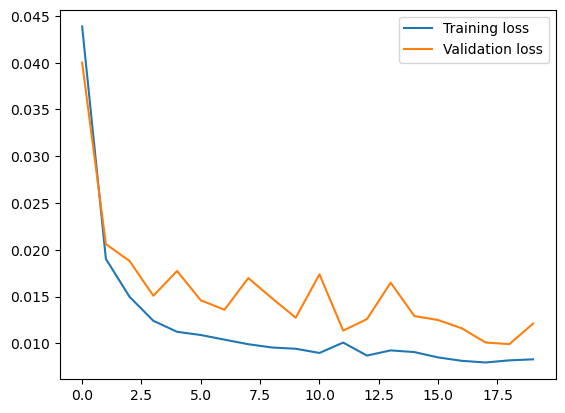

In [140]:
history = model.fit(trainX,trainY,epochs = 20,batch_size = 64,validation_split =0.1,verbose = 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Sacar métricas de lo que falla. Con el unique, ver a cual se acerca más. Sacar matrix_confusion, con este modelo.

### Ahora vamos a sacar todas las Y^ y todas las y.

In [141]:
y_real = testY.tolist()

In [142]:
y_pred = model.predict(testX)

2/2 [==============================] - 0s 10ms/step


In [143]:
uniques = set(tuple(x) for x in y_real)
uniques = [list(x) for x in uniques]

### Ahora tenemos que sacar las demás métricas y como tenemos 4 clases

### El número de stint que más veces aparece en el conjunto de test, ¿qué porcentaje sobre el total supone? 

In [144]:
frecuencias = {}

y_real_ = [sublista[0] for sublista in y_real]
frecuencias = {}
numero_mas_frecuente = None
frecuencia_maxima = 0

for numero in y_real_:
    if numero in frecuencias:
        frecuencias[numero] += 1
    else:
        frecuencias[numero] = 1

    if frecuencias[numero] > frecuencia_maxima:
        frecuencia_maxima = frecuencias[numero]
        numero_mas_frecuente = numero

print("El número que aparece con más frecuencia es:", numero_mas_frecuente)
print("Las frecuencias de cada número son:")
total = len(y_real_)

for numero, frecuencia in frecuencias.items():
    print(numero, "aparece", frecuencia, "veces que supone un", round((frecuencia/total)*100, 2), "del total")
    

El número que aparece con más frecuencia es: 0.6666666666666667
Las frecuencias de cada número son:
0.0 aparece 3 veces que supone un 5.56 del total
0.3333333333333333 aparece 20 veces que supone un 37.04 del total
0.6666666666666667 aparece 31 veces que supone un 57.41 del total


In [145]:
clases = sorted([sublista[0] for sublista in uniques])
clases

[0.0, 0.3333333333333333, 0.6666666666666667]

In [146]:
y_pred_normalized = []
for val in y_pred:
    dist = [abs(val-x) for x in clases]
    closest_val = uniques[np.argmin(dist)][0]
    y_pred_normalized.append(closest_val)

In [147]:
y_real_str = [str(value[0]) for value in y_real]
y_pred_normalized_str = [str(value) for value in y_pred_normalized]

In [148]:
from sklearn.metrics import confusion_matrix, classification_report
# Calcular la matriz de confusión
cm = confusion_matrix(y_real_str, y_pred_normalized_str, labels=clases)

# Imprimir la matriz de confusión
print("Matriz de confusión:")
print(clases)
print(cm)

# Imprimir las métricas básicas
print("Métricas:")
print(classification_report(y_real_str, y_pred_normalized_str, labels=clases))

Matriz de confusión:
[0.0, 0.3333333333333333, 0.6666666666666667]
[[0 0 0]
 [0 0 0]
 [0 0 0]]
Métricas:
                    precision    recall  f1-score   support

               0.0       0.16      1.00      0.27         3
0.3333333333333333       0.00      0.00      0.00        20
0.6666666666666667       0.89      1.00      0.94        31

         micro avg       0.63      0.63      0.63        54
         macro avg       0.35      0.67      0.40        54
      weighted avg       0.52      0.63      0.55        54



/Users/sergio/.local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sergio/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergio/.local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/Users/sergio/.local/lib/python3.10/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 